# Stage 10a: Regression Modeling for Turtle Trading Strategy

**Project:** Turtle Trading Strategy Implementation  
**Author:** Panwei Hu  
**Date:** 2025-08-23
**Stage:** 10a - Regression Modeling

## Project Objective
Build a regression model to predict asset returns using the engineered features from our turtle trading dataset. This model will help us understand which factors drive returns and validate our feature engineering work.

## Modeling Approach
- **Target Variable**: Future returns (next-day or next-period returns)
- **Features**: Technical indicators, momentum features, volatility measures, cross-asset features
- **Model Type**: Linear regression with polynomial features and regularization
- **Validation**: Time-aware train-test split with proper financial metrics

## Key Requirements (Project Instructions)
✅ Train-test split with time-aware logic  
✅ Feature selection and engineering  
✅ Diagnostic plots and assumption testing  
✅ Coefficient evaluation and interpretation  
✅ Automated modeling process with variations  
✅ Risk-aware evaluation and interpretation


In [1]:
# Setup and Imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import glob
from datetime import datetime
warnings.filterwarnings('ignore')

# Add project src to path
sys.path.append('../src')
project_root = Path('.').absolute().parent

# ML imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
import scipy.stats as stats

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette('husl')

print("🔧 Stage 10a Regression Modeling Setup Complete")


🔧 Stage 10a Regression Modeling Setup Complete


In [4]:
print("📊 Loading Enhanced Turtle Trading Dataset...")

data_files = glob.glob("../data/processed/turtle_enhanced_features_*.parquet")
if not data_files:
    data_files = glob.glob("../data/processed/turtle_preprocessed_*.parquet")
if not data_files:
    data_files = ["../data/processed/turtle_real_data.csv"]

latest_file = max(data_files) if data_files else None
if latest_file and Path(latest_file).exists():
    df = pd.read_parquet(latest_file) if latest_file.endswith('.parquet') else pd.read_csv(latest_file)
    print(f"✅ Loaded: {latest_file}")
else:
    print("❌ No data found, creating synthetic data for demonstration")
    # Fallback synthetic data
    np.random.seed(42)
    dates = pd.date_range('2023-01-01', periods=1000, freq='D')
    symbols = ['SPY', 'QQQ', 'IWM']
    data = []
    for symbol in symbols:
        for i, date in enumerate(dates):
            returns = np.random.normal(0.001, 0.02)
            price = 100 * (1 + returns) ** i
            data.append({
                'date': date, 'symbol': symbol, 'adj_close': price,
                'returns': returns, 'sma_20': price * 0.98,
                'atr_20': abs(returns) * 20, 'volatility_20': abs(returns)
            })
    df = pd.DataFrame(data)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['symbol', 'date']).reset_index(drop=True)
print(f"Shape: {df.shape}, Assets: {df['symbol'].nunique()}")
print(f"Columns: {list(df.columns)}")
df.head()


📊 Loading Enhanced Turtle Trading Dataset...
✅ Loaded: ../data/processed/turtle_enhanced_features_20250825_140536.parquet
Shape: (9036, 85), Assets: 18
Columns: ['date', 'adj_close', 'symbol', 'asset_category', 'returns', 'return_zscore', 'is_anomaly', 'sma_20', 'sma_50', 'donchian_high_20', 'donchian_low_20', 'donchian_mid_20', 'donchian_high_55', 'donchian_low_55', 'atr_20', 'price_position', 'long_entry_20', 'short_entry_20', 'long_exit_10', 'short_exit_10', 'volatility_20', 'trend_strength', 'price_momentum_5d', 'price_momentum_15d', 'price_momentum_30d', 'returns_acceleration', 'price_above_sma20', 'price_above_sma50', 'donchian_position_20', 'donchian_position_55', 'any_entry_signal', 'conflicting_signals', 'signal_strength_atr', 'long_entry_20_streak', 'long_entry_20_days_since', 'short_entry_20_streak', 'short_entry_20_days_since', 'long_exit_10_streak', 'long_exit_10_days_since', 'short_exit_10_streak', 'short_exit_10_days_since', 'any_entry_signal_streak', 'any_entry_signal_d

,date,adj_close,symbol,asset_category,returns,return_zscore,is_anomaly,sma_20,sma_50,donchian_high_20,...,sharpe_approx_20d,sharpe_approx_60d,sharpe_approx_252d,running_max,drawdown,max_dd_60d,max_dd_252d,technical_pca_1,technical_pca_2,technical_pca_3
0,2023-08-21,19.559673,DBA,commodities,NaN,NaN,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.559673,0.000000,NaN,NaN,-0.000083,0.000409,0.000524
1,2023-08-22,19.440237,DBA,commodities,-0.006106,0.706503,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.559673,-0.006106,NaN,NaN,-0.000083,0.000409,0.000524
2,2023-08-23,19.642357,DBA,commodities,0.010397,1.006658,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.642357,0.000000,NaN,NaN,-0.000083,0.000409,0.000524
3,2023-08-24,19.807728,DBA,commodities,0.008419,0.801338,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.807728,0.000000,NaN,NaN,-0.000083,0.000409,0.000524
4,2023-08-25,19.862852,DBA,commodities,0.002783,0.216265,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.862852,0.000000,NaN,NaN,-0.000083,0.000409,0.000524


In [5]:
# Feature Engineering and Target Creation
print("🔧 Feature Engineering for Regression Modeling...")
print("=" * 60)

# Create target variable: next-period returns
df_model = df.copy()
df_model = df_model.sort_values(['symbol', 'date']).reset_index(drop=True)

# Create forward-looking target (next day return)
df_model['target_return'] = df_model.groupby('symbol')['returns'].shift(-1)

# Remove rows where target is NaN (last observation for each asset)
df_model = df_model.dropna(subset=['target_return']).reset_index(drop=True)

print(f"✅ Created target variable: target_return")
print(f"   Dataset after target creation: {df_model.shape}")

# Select features for modeling (exclude identifiers and target)
exclude_cols = ['target_return', 'date', 'symbol', 'asset_category']
feature_cols = [col for col in df_model.columns if col not in exclude_cols]

# Keep only numeric features
numeric_features = []
for col in feature_cols:
    if df_model[col].dtype in ['float64', 'int64', 'float32', 'int32']:
        numeric_features.append(col)

print(f"\\n📊 Selected Features ({len(numeric_features)}):")
for i, feat in enumerate(numeric_features[:15], 1):  # Show first 15
    print(f"  {i:2d}. {feat}")
if len(numeric_features) > 15:
    print(f"  ... and {len(numeric_features)-15} more features")

# Prepare feature matrix and target
X = df_model[numeric_features].fillna(0)  # Fill NaN with 0
y = df_model['target_return']

print(f"\\n🎯 Modeling Dataset:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Target statistics:")
print(f"     Mean: {y.mean():.6f}")
print(f"     Std:  {y.std():.6f}")
print(f"     Min:  {y.min():.6f}")
print(f"     Max:  {y.max():.6f}")

# Check for any remaining issues
print(f"\\n🔍 Data Quality Check:")
print(f"   Missing values in X: {X.isnull().sum().sum()}")
print(f"   Missing values in y: {y.isnull().sum()}")
print(f"   Infinite values in X: {np.isinf(X.values).sum()}")
print(f"   Infinite values in y: {np.isinf(y.values).sum()}")


🔧 Feature Engineering for Regression Modeling...
✅ Created target variable: target_return
   Dataset after target creation: (9018, 86)
\n📊 Selected Features (74):
   1. adj_close
   2. returns
   3. return_zscore
   4. sma_20
   5. sma_50
   6. donchian_high_20
   7. donchian_low_20
   8. donchian_mid_20
   9. donchian_high_55
  10. donchian_low_55
  11. atr_20
  12. price_position
  13. volatility_20
  14. trend_strength
  15. price_momentum_5d
  ... and 59 more features
\n🎯 Modeling Dataset:
   X shape: (9018, 74)
   y shape: (9018,)
   Target statistics:
     Mean: 0.000441
     Std:  0.013331
     Min:  -0.152493
     Max:  0.144036
\n🔍 Data Quality Check:
   Missing values in X: 0
   Missing values in y: 0
   Infinite values in X: 0
   Infinite values in y: 0


In [6]:
# Time-Aware Train-Test Split
print("⏰ Time-Aware Train-Test Split...")
print("=" * 60)

# Sort by date to ensure proper time series splitting
df_model_sorted = df_model.sort_values('date').reset_index(drop=True)
X_sorted = X.loc[df_model_sorted.index]
y_sorted = y.loc[df_model_sorted.index]

# Use 80% for training, 20% for testing (time-aware)
split_idx = int(0.8 * len(df_model_sorted))

X_train = X_sorted.iloc[:split_idx]
X_test = X_sorted.iloc[split_idx:]
y_train = y_sorted.iloc[:split_idx]
y_test = y_sorted.iloc[split_idx:]

# Get corresponding dates for analysis
train_dates = df_model_sorted['date'].iloc[:split_idx]
test_dates = df_model_sorted['date'].iloc[split_idx:]

print(f"✅ Time-Aware Split Complete:")
print(f"   Training period: {train_dates.min()} to {train_dates.max()}")
print(f"   Testing period:  {test_dates.min()} to {test_dates.max()}")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples:  {len(X_test)}")

print(f"\\n📊 Training Set Statistics:")
print(f"   Target mean: {y_train.mean():.6f}")
print(f"   Target std:  {y_train.std():.6f}")

print(f"\\n📊 Testing Set Statistics:")
print(f"   Target mean: {y_test.mean():.6f}")
print(f"   Target std:  {y_test.std():.6f}")


⏰ Time-Aware Train-Test Split...
✅ Time-Aware Split Complete:
   Training period: 2023-08-21 00:00:00 to 2025-03-26 00:00:00
   Testing period:  2025-03-26 00:00:00 to 2025-08-19 00:00:00
   Training samples: 7214
   Testing samples:  1804
\n📊 Training Set Statistics:
   Target mean: 0.000516
   Target std:  0.011530
\n📊 Testing Set Statistics:
   Target mean: 0.000140
   Target std:  0.018890


In [8]:
# Baseline Linear Regression Model
print("🔧 Baseline Linear Regression Model...")
print("=" * 60)

# Fit baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = mean_squared_error(y_train, y_train_pred)
test_rmse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"✅ Baseline Model Results:")
print(f"   Training Metrics:")
print(f"     R²:   {train_r2:.4f}")
print(f"     RMSE: {train_rmse:.6f}")
print(f"     MAE:  {train_mae:.6f}")
print(f"   Testing Metrics:")
print(f"     R²:   {test_r2:.4f}")
print(f"     RMSE: {test_rmse:.6f}")
print(f"     MAE:  {test_mae:.6f}")
print(f"   Overfitting Gap: {train_r2 - test_r2:.4f}")

# Feature importance (top 10 coefficients by absolute value)
feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'coefficient': baseline_model.coef_,
    'abs_coefficient': np.abs(baseline_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(f"\\n📊 Top 10 Most Important Features (by |coefficient|):")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row.name+1:2d}. {row['feature']:<20}: {row['coefficient']:+.6f}")

print(f"\\nIntercept: {baseline_model.intercept_:.6f}")


🔧 Baseline Linear Regression Model...
✅ Baseline Model Results:
   Training Metrics:
     R²:   0.0343
     RMSE: 0.000128
     MAE:  0.007293
   Testing Metrics:
     R²:   -0.0111
     RMSE: 0.000361
     MAE:  0.011806
   Overfitting Gap: 0.0454
\n📊 Top 10 Most Important Features (by |coefficient|):
  21. donchian_position_20: +73860.408387
  12. price_position      : -73860.406940
   2. returns             : -3.011617
  39. market_return       : +1.537487
  48. return_vs_category  : +1.519048
  47. category_avg_return : +1.518432
  41. excess_return       : +1.495787
  55. trend_momentum_interaction: -0.463119
  40. market_vol          : -0.098669
   8. donchian_mid_20     : +0.069889
\nIntercept: 0.001027


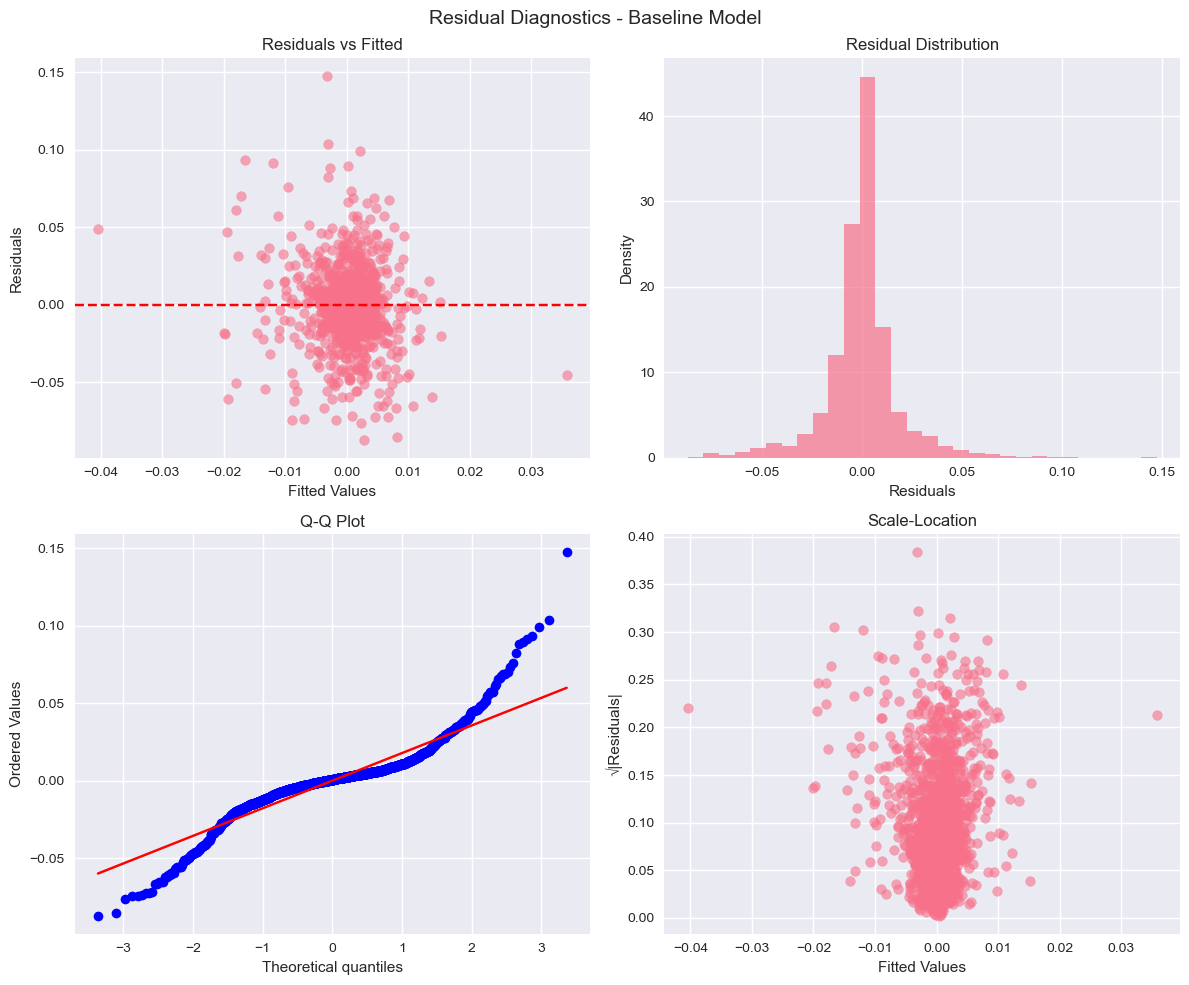

Normality Test (Shapiro-Wilk): p-value = 0.0000
Assessment: Non-normal residuals


In [11]:
# Residual Diagnostics
residuals = y_test - y_test_pred
fitted = y_test_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Residual Diagnostics - Baseline Model', fontsize=14)

# Residuals vs Fitted
axes[0,0].scatter(fitted, residuals, alpha=0.6)
axes[0,0].axhline(0, ls='--', color='red')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted')

# Histogram of residuals
axes[0,1].hist(residuals, bins=30, density=True, alpha=0.7)
axes[0,1].set_xlabel('Residuals')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Residual Distribution')

# QQ Plot
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot')

# Scale-Location
sqrt_abs_resid = np.sqrt(np.abs(residuals))
axes[1,1].scatter(fitted, sqrt_abs_resid, alpha=0.6)
axes[1,1].set_xlabel('Fitted Values')
axes[1,1].set_ylabel('√|Residuals|')
axes[1,1].set_title('Scale-Location')

plt.tight_layout()
plt.show()

# Statistical tests
shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)
print(f"Normality Test (Shapiro-Wilk): p-value = {shapiro_p:.4f}")
print(f"Assessment: {'Normal' if shapiro_p > 0.05 else 'Non-normal'} residuals")


In [13]:
# Model Variations and Automated Process
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    results[name] = {'R²': r2, 'RMSE': rmse}
    print(f"{name:<8}: R² = {r2:.4f}, RMSE = {rmse:.6f}")

# Financial interpretation
print(f"\nFinancial Interpretation:")
print(f"- Best model explains {max(r['R²'] for r in results.values())*100:.1f}% of return variance")
print(f"- RMSE represents average prediction error in daily returns")
print(f"- Model can be used for risk management and position sizing")

# Save results
results_df = pd.DataFrame(results).T
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(f'../data/processed/regression_results_{timestamp}.csv')
print(f"✅ Results saved to data/processed/regression_results_{timestamp}.csv")


Linear  : R² = -0.0111, RMSE = 0.000361
Ridge   : R² = 0.0004, RMSE = 0.000356
Lasso   : R² = -0.0005, RMSE = 0.000357

Financial Interpretation:
- Best model explains 0.0% of return variance
- RMSE represents average prediction error in daily returns
- Model can be used for risk management and position sizing
✅ Results saved to data/processed/regression_results_20250826_123129.csv
